In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from ggplot import *

## Panier alimentaire idéal
Voici la répartition du panier alimentaire équilibré tel que défini par la Croix-Rouge
<img src="panier.png">
### Objectifs
- Etape 1 : Recomposer sur 2014 la répartition hebdo des paniers sur un maximum de centres
- Etape 2 : Mettre en place un score pour noter l'équilibre alimentaire sur une semaine
- Etape 3 : Viz -> Sélection du centre > Accès aux semaines via un carré coloré reprenant le score > accès au camembert de la semaine

## Correspondance des catégories au sein de la table itmcorres

Catégories de produit défines dans la base :

In [2]:
query = """SELECT
cat2,
COUNT(cat2) as nb_item
FROM [stojou.itmcorres]
GROUP BY cat2"""

cat = pd.read_gbq(query,project_id='croix-rouge-92715')
cat

Waiting for job to complete...


,cat2,nb_item
0,FL,13365
1,VOP,17841
2,PGS,40183
3,LPL,10509
4,FEC,9760
5,EAU,829
6,MTG,3537
7,HYG,3374
8,ETM,1493
9,CDM,2958


In [3]:
mapping_cat = {
    "FL": "Fruits Legumes",
    "PL2": "Produits laitiers",
    "LPL": "Produits laitiers",
    "VOP": "Viandes, oeuf, poisson",
    "PFM": "Viandes, oeuf, poisson", #PFM = Poissons, Fruits de mer ?
    "MTG": "Matieres grasses ajoutees",
    "FEC": "Feculents",
    "PGS": "Produits gras, sucres ou sales",
    "EAU": "Hygiene, eau",
    "HYG": "Hygiene, eau",
    "SUC": "Autres",
    "CET": "Autres",
    "ACN": "Autres",
    "CHE": "Autres",
    "CSN": "Autres",
    "DGR": "Autres",
    "CAP": "Autres",
    "BON": "Autres",
    "BUR": "Autres",
    "PDP": "Autres",
    "ACL": "Autres",
    "PDV": "Autres",
    "ETL": "Autres",
    "CFT": "Autres",
    "ACH": "Autres",
    "CDM": "Autres",
    "ETM": "Autres",
    "MAT": "Autres"    
}

In [4]:
cat['new_catego'] = cat["cat2"].map(mapping_cat)
cat

,cat2,nb_item,new_catego
0,FL,13365,Fruits Legumes
1,VOP,17841,"Viandes, oeuf, poisson"
2,PGS,40183,"Produits gras, sucres ou sales"
3,LPL,10509,Produits laitiers
4,FEC,9760,Feculents
5,EAU,829,"Hygiene, eau"
6,MTG,3537,Matieres grasses ajoutees
7,HYG,3374,"Hygiene, eau"
8,ETM,1493,Autres
9,CDM,2958,Autres


Query ci-dessous :
- Dont le numéro de pièce (VCRNUM_0) commence par "DIS" pour Distribution
- Sur 2014
- Pour le 91,92,93,94,95 (et déjà la query prend un peu de temps, patience ! ;) )


In [5]:
query = """SELECT
  date,
  cat2,
  dpt_nb,
  OWNER_0 Centre,
  Qty,
  VCRNUM_0 num_piece,
  Invoice.BPR beneficiaire_id,
  Invoice.YNBR taille_foyer
FROM (
Select 
  TIMESTAMP(CONCAT('20',SUBSTRING(IPTDAT_0,7,2),'-',SUBSTRING(IPTDAT_0,4,2),'-',SUBSTRING(IPTDAT_0,1,2), ' 00:00:00')) date,
  MONTH(TIMESTAMP(CONCAT('20',SUBSTRING(IPTDAT_0,7,2),'-',SUBSTRING(IPTDAT_0,4,2),'-',SUBSTRING(IPTDAT_0,1,2), ' 00:00:00'))) month,
  YEAR(TIMESTAMP(CONCAT('20',SUBSTRING(IPTDAT_0,7,2),'-',SUBSTRING(IPTDAT_0,4,2),'-',SUBSTRING(IPTDAT_0,1,2), ' 00:00:00'))) year,
  OWNER_0,
  ITMREF_0,
  CAST(QTYSTU_0 AS INTEGER) Qty,
  corres.cat2 AS cat2,
  VCRNUM_0
FROM [stojou.stojou] input
  JOIN (
    SELECT
      itemref,cat2
    FROM
      [stojou.itmcorres]) corres
    ON
      input.ITMREF_0 = corres.itemref
    #WHERE corres.cat2 IN ('FL','FEC','VOP','LPL','PGS','PFM','PL2')
    
    ) AS joined
  
  JOIN (
    SELECT
      CD_U2A, CD_DEPT dpt_nb
    FROM
      [stojou.dim_u2a_ville]) dpt
  ON
    joined.OWNER_0 = dpt.CD_U2A
  LEFT JOIN (
    SELECT
      NUM,
      BPR,
      YNBR
    FROM
     [stojou.SINVOICE_M]) Invoice
  ON Invoice.NUM = joined.VCRNUM_0
    
WHERE
date >= TIMESTAMP('2014-01-01  00:00:00') AND
dpt_nb in ('93','92','91','94','95') AND
SUBSTRING(VCRNUM_0,0,3) == "DIS"
"""

paniers = pd.read_gbq(query,project_id='croix-rouge-92715')

Waiting for job to complete...
Waiting for job to complete...


In [6]:
paniers.head(10)

,date,cat2,dpt_nb,Centre,Qty,num_piece,beneficiaire_id,taille_foyer
0,2014-11-06,FL,92,U9203,-4,DIS141106009378,140180617,1
1,2014-11-06,HYG,92,U9203,-1,DIS141106009473,130124968,1
2,2014-11-06,LPL,92,U9203,-1,DIS141106009473,130124968,1
3,2014-11-06,FL,92,U9203,-8,DIS141106009473,130124968,1
4,2014-11-04,LPL,95,U9504,-3,DIS141104002483,140183698,2
5,2014-11-04,PGS,95,U9504,-1,DIS141104002483,140183698,2
6,2014-11-04,CFT,95,U9504,-1,DIS141104002483,140183698,2
7,2014-11-04,FEC,95,U9504,-1,DIS141104002483,140183698,2
8,2014-11-04,HYG,95,U9504,-1,DIS141104002483,140183698,2
9,2014-11-04,PGS,95,U9504,-1,DIS141104002483,140183698,2


In [7]:
paniers = paniers.set_index(paniers['date'])

In [8]:
paniers['catego'] = paniers['cat2'].map(mapping_cat)

### Nettoyage : unusual quantities et centres inactifs
Après quelques essais, j'ai retenu comme "unusual quantity" le seuil de 20 produits identiques distribués à la même personnes.

In [9]:
paniers['taille_foyer'] = paniers['taille_foyer'].astype('int64')
unusual_qty = paniers[(paniers['Qty'] < -20) & (paniers['taille_foyer'] < 2)]
beneficiary_excluded = unusual_qty['Qty'].groupby(unusual_qty['beneficiaire_id']).sum().index

On exclut les bénéficiaires pour qui les quantités distribuées sont suspectes

In [10]:
paniers = paniers[~paniers['beneficiaire_id'].isin(beneficiary_excluded)]

Les Quantités positives semblent correspondre à des annulations en caisse (voir exemple ci-dessous).

On les sommera donc au moment de déterminer notre panier moyen.

In [11]:
paniers[paniers['num_piece'] == 'DIS140904005596']

,date,cat2,dpt_nb,Centre,Qty,num_piece,beneficiaire_id,taille_foyer,catego
date,,,,,,,,,
2014-09-04,2014-09-04,LPL,93,U9308,-2,DIS140904005596,140170353,4,Produits laitiers
2014-09-04,2014-09-04,FL,93,U9308,-2,DIS140904005596,140170353,4,Fruits Legumes
2014-09-04,2014-09-04,PGS,93,U9308,-1,DIS140904005596,140170353,4,"Produits gras, sucres ou sales"
2014-09-04,2014-09-04,FEC,93,U9308,-1,DIS140904005596,140170353,4,Feculents
2014-09-04,2014-09-04,CFT,93,U9308,-1,DIS140904005596,140170353,4,Autres
2014-09-04,2014-09-04,FEC,93,U9308,-1,DIS140904005596,140170353,4,Feculents
2014-09-04,2014-09-04,PGS,93,U9308,-1,DIS140904005596,140170353,4,"Produits gras, sucres ou sales"
2014-09-04,2014-09-04,FEC,93,U9308,1,DIS140904005596,140170353,4,Feculents
2014-09-04,2014-09-04,FL,93,U9308,-1,DIS140904005596,140170353,4,Fruits Legumes


On enlève les centres où trop peu a été distribué

In [12]:
par_centre = paniers['Qty'].groupby(paniers['Centre']).sum()

In [13]:
centres_actifs = par_centre[ par_centre < -1000]
centres_actifs.index

Index([u'U9101', u'U9102', u'U9103', u'U9105', u'U9201', u'U9203', u'U9206',
       u'U9208', u'U9211', u'U9213', u'U9301', u'U9306', u'U9308', u'U9314',
       u'U9401', u'U9501', u'U9504', u'U9506', u'U9508'],
      dtype='object', name=u'Centre')

In [14]:
paniers = paniers[paniers['Centre'].isin(centres_actifs.index)]

### Détermination du panier moyen hebdo par centre et par semaine

On pondère la répartition des paniers par le nombre de personnes composant le foyer.

In [15]:
panier_serie = paniers['Qty'].groupby([paniers['date'],paniers['Centre'],paniers['num_piece'], paniers['catego'],paniers['taille_foyer']]).sum()

In [16]:
panier_serie = panier_serie.unstack().fillna(0)

/usr/local/lib/python2.7/site-packages/pandas/core/index.py:4281: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return np.sum(name == np.asarray(self.names)) > 1


In [17]:
for col in list(panier_serie.columns.values):
    panier_serie[col] = col * panier_serie[col]

In [18]:
panier_serie['Total'] = panier_serie.sum(1)

In [19]:
for col in [1,2,3,4,5,6,7,9,10]:
    panier_serie = panier_serie.drop(col,1)

On bidouille les Multi Index pour arriver à un % par produit et par centre

In [20]:
grouped = panier_serie.unstack(1).unstack()

In [21]:
by_date = grouped.reset_index(1,drop=True).fillna(0)

In [22]:
by_week = by_date.resample('W',how='sum').fillna(0)

In [23]:
by_week.columns.droplevel(0)

MultiIndex(levels=[[u'U9101', u'U9102', u'U9103', u'U9105', u'U9201', u'U9203', u'U9206', u'U9208', u'U9211', u'U9213', u'U9301', u'U9306', u'U9308', u'U9314', u'U9401', u'U9501', u'U9504', u'U9506', u'U9508'], [u'Autres', u'Feculents', u'Fruits Legumes', u'Hygiene, eau', u'Matieres grasses ajoutees', u'Produits gras, sucres ou sales', u'Produits laitiers', u'Viandes, oeuf, poisson']],
           labels=[[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 

In [24]:
by_week = by_week['Total']

In [25]:
Centres = by_week.columns.get_level_values(0)

In [26]:
by_week_percent = by_week
for Centre in Centres:
    tmp = by_week[Centre]
    rowSum = tmp.sum(1)
    by_week_percent[Centre] = tmp.divide(rowSum,axis=0) * 100

In [27]:
by_week_percent

Centre         U9101                                         \
catego        Autres  Feculents Fruits Legumes Hygiene, eau   
date                                                          
2014-01-05  6.953148  10.474485      17.785736           -0   
2014-01-12  3.994614   8.587672      19.210054           -0   
2014-01-19  6.351503  11.255829      21.788069           -0   
2014-01-26 -0.000000   9.824958      23.771880           -0   
2014-02-02  0.027439  13.609549      16.490602           -0   
2014-02-09 -0.000000   8.713312      19.614780           -0   
2014-02-16  0.072508   7.879154      12.314199           -0   
2014-02-23  2.906568   7.358623      31.708816           -0   
2014-03-02  0.088183   9.954928      27.542622           -0   
2014-03-09  0.205672   8.594934      22.905391           -0   
2014-03-16  0.007868  10.857592      27.710464           -0   
2014-03-23  3.364666  14.120914      20.369579           -0   
2014-03-30  0.583294  13.847410      20.870275           -0   
2014-04-06  0.011573   9.975697      16.711029           -0   
2014-04-13 -0.000000  14.742384      13.714429           -0   
2014-04-20  4.888473  10.898891      17.617203           -0   
2014-04-27  0.816591  13.311730      17.394686           -0   
2014-05-04 -0.000000  18.407534      28.339041           -0   
2014-05-11  0.193686  14.720124      38.330428           -0   
2014-05-18  0.264410  12.109995      21.628768           -0   
2014-05-25  4.890545   9.047508      20.691663           -0   
2014-06-01  0.289250   9.497027      18.961915           -0   
2014-06-08  0.012832  11.407674      16.168356           -0   
2014-06-15 -0.000000  12.196135       7.749844           -0   
2014-06-22  1.625177   9.918741      11.995357           -0   
2014-06-29  5.430479  13.666704      12.150696           -0   
2014-07-06       NaN        NaN            NaN          NaN   
2014-07-13       NaN        NaN            NaN          NaN   
2014-07-20       NaN        NaN            NaN          NaN   
2014-07-27       NaN        NaN            NaN          NaN   
2014-08-03       NaN        NaN            NaN          NaN   
2014-08-10       NaN        NaN            NaN          NaN   
2014-08-17       NaN        NaN            NaN          NaN   
2014-08-24  5.006310  15.355490      18.300379           -0   
2014-08-31  8.240309  10.330830       9.478384           -0   
2014-09-07  0.618132  14.674908      17.788462           -0   
2014-09-14  0.510517  12.231979      15.662651           -0   
2014-09-21  5.642903  13.805729      16.670256           -0   
2014-09-28  5.858171  14.045906      17.694416           -0   
2014-10-05  0.178006  19.442247      14.438291           -0   
2014-10-12  5.669380  13.177098      13.527926           -0   
2014-10-19  3.061674  24.273128      26.145374           -0   
2014-10-26  2.138158  21.076128      28.735902           -0   
2014-11-02  4.235624  15.904628      21.711080           -0   
2014-11-09  2.475000   8.250000      17.800000           -0   
2014-11-16  3.619612   8.687068      17.900625           -0   
2014-11-23  8.785872  22.516556      27.549669           -0   
2014-11-30  9.522267   8.728745      16.809717           -0   
2014-12-07       NaN        NaN            NaN          NaN   

Centre                                                               \
catego     Matieres grasses ajoutees Produits gras, sucres ou sales   
date                                                                  
2014-01-05                 10.832587                       8.892868   
2014-01-12                  0.179533                      25.179533   
2014-01-19                  0.048239                      13.281878   
2014-01-26                  0.663467                      13.212874   
2014-02-02                  0.027439                      15.255865   
2014-02-09                 10.010482                       9.696017   
2014-02-16                  0.483384                      27.504532   
2014-02-23   

## Juste pour le fun un petit example sur le premier centre

In [75]:
example = by_week_percent['U9101'][by_week_percent.index == by_week_percent.index[0]]

In [76]:
example

catego,Autres,Feculents,Fruits Legumes,"Hygiene, eau",Matieres grasses ajoutees,"Produits gras, sucres ou sales",Produits laitiers,"Viandes, oeuf, poisson"
date,,,,,,,,
2014-01-05,6.953148,10.474485,17.785736,-0,10.832587,8.892868,30.19994,14.861235


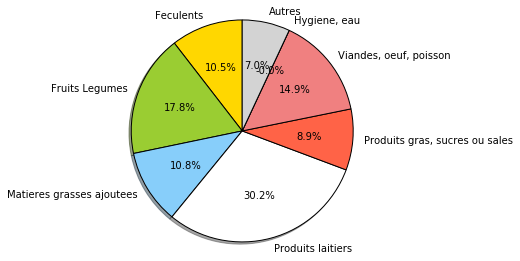

In [77]:
labels = example.columns[1],example.columns[2],example.columns[4],example.columns[6],example.columns[5],example.columns[7],example.columns[3],example.columns[0]
sizes = [example.iloc[0][1], example.iloc[0][2], example.iloc[0][4], example.iloc[0][6],example.iloc[0][5],example.iloc[0][7],example.iloc[0][3],example.iloc[0][0]]
colors = ['gold','yellowgreen', 'lightskyblue', 'white','tomato','lightcoral','lightblue','lightgray']

plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')

fig = plt.figure()

Next in line :
- Checker les NaN des centres et ne lister les centres que pour lesquels il y a suffisamment de valeurs
- Commencer à bosser sur une première version d'un score